In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def dyke_equation(x, z, d, theta, K, x0):
    term1 = K * (np.sin(theta) * (np.arctan2(x - x0 + d, z) - np.arctan2(x - x0 - d, z)))
    term2 = (np.cos(theta) / 2) * (np.log(((x - x0 + d) ** 2 + z ** 2) / ((x - x0 - d) ** 2 + z ** 2)))
    return term1 - term2

z_values = np.linspace(10, 70, 900)  # Depth values
d = 10 #np.linspace(5, 20, 20)    # half Width values
theta_values = np.pi/6 # np.linspace(0, np.pi/2, 20)  # Inclination values
K =np.linspace(100, 400, 900)  #Effective Magnetisation Intensity
x0 =4 # np.linspace(0, 8, 50)   # x0 values
amp=[]
mean=[]
std=[]
x_values = np.linspace(-40, 40, 900)
magnetic_anomalies_matrix = np.zeros((900, 900))


for i in range(len(z_values)):  #getting magnetic data by varying z and K
        
        
        magnetic_anomalies = []
        for x in x_values:
            magnetic_anomalies.append(dyke_equation(x, z_values[i], d, theta_values, K[i], x0))
        magnetic_anomalies_matrix[i] = magnetic_anomalies
        amp.append(max(magnetic_anomalies_matrix[i,:]))
        mean.append(np.mean(magnetic_anomalies_matrix[i,:]))
        std.append(np.std(magnetic_anomalies_matrix[i,:]))


derivatives = abs(np.gradient(magnetic_anomalies_matrix, axis=1))

deriv_sum = derivatives.sum(axis=1)
        

    
df_sum_slope=pd.DataFrame({'sum_slope':deriv_sum})
df_std = pd.DataFrame({'std':std})
df_mean = pd.DataFrame({'mean':mean })
df_amp = pd.DataFrame({'amp':amp })
df_depth = pd.DataFrame({'Depth': z_values})
df_k = pd.DataFrame({'K': K})

df_combined = pd.concat([df_depth, df_k,df_amp,df_mean,df_std,df_sum_slope], axis=1)


# Write combined DataFrame to Excel file
df_combined.to_excel('test.xlsx', sheet_name='sheet1', index=False)


C:\Users\prate\AppData\Local\Temp\ipykernel_11908\4049984880.py:9: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


Reloading Tuner from hyperparameter_tuning\dyke_model\tuner0.json
Best Hyperparameters:
Epoch 1/50


17/17 [==============================] - 1s 16ms/step - loss: 18365.1973 - mae: 94.4207 - val_loss: 9038.3545 - val_mae: 62.3196
Epoch 2/50
17/17 [==============================] - 0s 6ms/step - loss: 6026.2114 - mae: 55.7581 - val_loss: 2776.3970 - val_mae: 34.8160
Epoch 3/50
17/17 [==============================] - 0s 6ms/step - loss: 1563.7559 - mae: 26.3495 - val_loss: 321.1705 - val_mae: 11.3549
Epoch 4/50
17/17 [==============================] - 0s 6ms/step - loss: 240.8976 - mae: 11.4867 - val_loss: 195.3086 - val_mae: 11.1765
Epoch 5/50
17/17 [==============================] - 0s 6ms/step - loss: 151.5897 - mae: 9.9526 - val_loss: 95.1296 - val_mae: 7.7498
Epoch 6/50
17/17 [==============================] - 0s 6ms/step - loss: 89.2097 - mae: 7.0651 - val_loss: 64.7602 - val_mae: 5.8120
Epoch 7/50
17/17 [==============================] - 0s 5ms/step - loss: 57.4691 - mae: 5.4558 

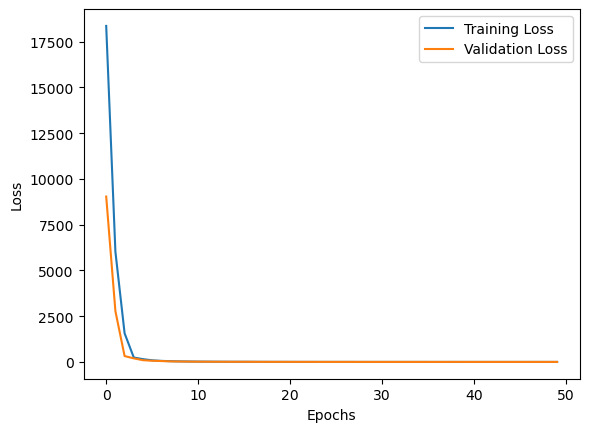

D:\Ananconda\envs\seismo\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [6]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from kerastuner.tuners import RandomSearch


data = pd.read_excel('test.xlsx')
X = data.iloc[:, 2:]  # Features
y = data.iloc[:, :2]  # Target variables


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.4, random_state=42)





def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units1', min_value=16, max_value=512, step=16),
                    activation=hp.Choice('activation1', values=['relu', 'tanh', 'linear']),
                    input_shape=(X_train.shape[1],)))

    for i in range(hp.Int('num_layers', min_value=1, max_value=10)):
        model.add(Dense(units=hp.Int(f'units_{i+2}', min_value=16, max_value=512, step=16),
                        activation=hp.Choice(f'activation_{i+2}', values=['relu', 'tanh', 'linear'])))
        model.add(Dropout(rate=hp.Float(f'dropout_{i+2}', min_value=0.0, max_value=0.5, step=0.1)))
    
    model.add(Dense(2, activation='linear'))  

    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='mse',
                  metrics=['mae'])
    return model

tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,
    directory='hyperparameter_tuning',
    project_name='dyke_model'
)

tuner.search(X_train, y_train, epochs=20, validation_data=(X_val, y_val),
             callbacks=[EarlyStopping('val_loss', patience=3)])  


best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters:\n{best_hps}")


best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val),
                          callbacks=[EarlyStopping('val_loss', patience=5)])

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

best_model.save('best_dyke_model_new.h5')


In [20]:
tuner.get_best_hyperparameters(num_trials=1)[0].values

{'units1': 64,
 'units2': 64,
 'learning_rate': 0.01,
 'activation1': 'relu',
 'num_layers': 1,
 'units_2': 16,
 'activation_2': 'relu',
 'dropout_2': 0.0}

In [25]:
import pandas as pd

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
hyperparameters_dict = best_hps.values

hyperparameters_dict_filtered = {key: value for key, value in hyperparameters_dict.items() if key not in ['num_layers', 'units_2']}


df = pd.DataFrame(list(hyperparameters_dict_filtered.items()), columns=['Hyperparameter', 'Value'])

print(df)


  Hyperparameter Value
0         units1    64
1         units2    64
2  learning_rate  0.01
3    activation1  relu
4   activation_2  relu
5      dropout_2   0.0


In [7]:

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model

data1 = pd.read_excel('test1.xlsx')
X_new = data1.iloc[:,2:]

print(X_new)

loaded_model = load_model('best_dyke_model_new.h5')

X_new_array = X_new.values.reshape(100, -1)
 

predictions = loaded_model.predict(X_new_array)

print("Predictions:")
print(predictions)


          amp       mean        std   sum_slope
0   92.731328  54.844698  24.364153  143.321353
1   91.667797  54.889572  23.814760  140.195164
2   90.643087  54.929943  23.281495  137.160018
3   89.655303  54.965981  22.763750  134.212402
4   88.702659  54.997850  22.260946  131.348980
..        ...        ...        ...         ...
95  57.242046  51.775325   4.658004   28.863322
96  57.118733  51.729070   4.596990   28.492852
97  56.997159  51.683019   4.537082   28.128930
98  56.877287  51.637174   4.478255   27.771413
99  56.759082  51.591538   4.420485   27.420164

[100 rows x 4 columns]
4/4 [==============================] - 0s 4ms/step
Predictions:
[[ 26.161396 199.65858 ]
 [ 26.742746 201.99979 ]
 [ 27.30835  204.27798 ]
 [ 27.858643 206.49466 ]
 [ 28.394056 208.65137 ]
 [ 28.915007 210.74957 ]
 [ 29.421886 212.79063 ]
 [ 29.915087 214.776   ]
 [ 30.39498  216.707   ]
 [ 30.861921 218.58496 ]
 [ 31.316267 220.4112  ]
 [ 31.758356 222.18695 ]
 [ 32.22269  224.09695 ]
 [ 32.70176

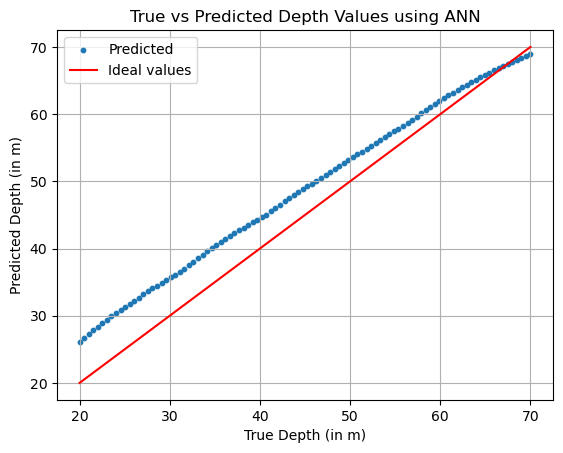

In [8]:
import matplotlib.pyplot as plt

Y10=data1.iloc[:,0]
Y11=data1.iloc[:,1]
plt.scatter(Y10, predictions[:, 0], label='Predicted', marker='o', s=10)  
plt.plot(Y10, Y10, color='red', label='Ideal values')  
plt.xlabel('True Depth (in m)') 
plt.ylabel('Predicted Depth (in m)')  
plt.grid(True)  
plt.title('True vs Predicted Depth Values using ANN')  
plt.legend()  
plt.show()  


In [9]:
from sklearn.metrics import r2_score

r_squared = r2_score(Y10, predictions[:,0])
print("Coefficient of Determination (R-squared):", r_squared)


Coefficient of Determination (R-squared): 0.9157776240194884


In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd





def dyke_equation(x, z, d, theta, K, x0):
    term1 = K * (np.sin(theta) * (np.arctan2(x - x0 + d, z) - np.arctan2(x - x0 - d, z)))
    term2 = (np.cos(theta) / 2) * (np.log(((x - x0 + d) ** 2 + z ** 2) / ((x - x0 - d) ** 2 + z ** 2)))
    return term1 - term2

z_values = Y10  # Depth values

d = 10 #np.linspace(5, 20, 20)    # half Width values
theta_values = np.pi/6 # np.linspace(0, np.pi/2, 20)  # Inclination values
K =Y11  #Effective Magnetisation Intensity
x0 =4 # np.linspace(0, 8, 50)   # x0 values
amp=[]
mean=[]
std=[]
x_values = np.linspace(-40, 40, 900)
magnetic_anomalies_matrix1 = np.zeros((100, 900))


for i in range(len(z_values)):  #getting magnetic data by varying z and K
        
        
        magnetic_anomalies = []
        for x in x_values:
            magnetic_anomalies.append(dyke_equation(x, z_values[i], d, theta_values, K[i], x0))
        magnetic_anomalies_matrix1[i] = magnetic_anomalies



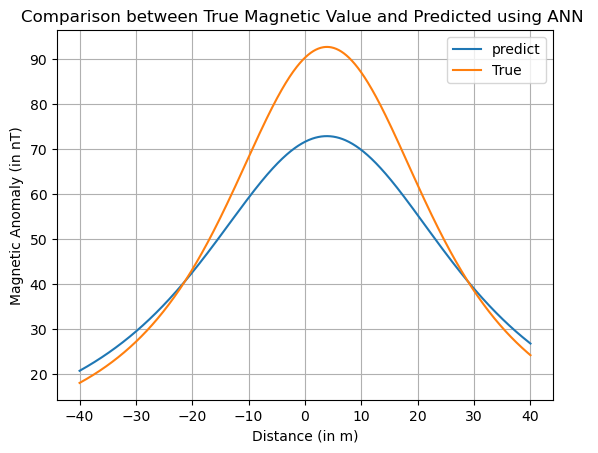

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def dyke_equation(x, z, d, theta, K, x0):
    term1 = K * (np.sin(theta) * (np.arctan2(x - x0 + d, z) - np.arctan2(x - x0 - d, z)))
    term2 = (np.cos(theta) / 2) * (np.log(((x - x0 + d) ** 2 + z ** 2) / ((x - x0 - d) ** 2 + z ** 2)))
    return term1 - term2

z_values = predictions[:,0]  # Depth values

d = 10 #np.linspace(5, 20, 20)    # half Width values
theta_values = np.pi/6 # np.linspace(0, np.pi/2, 20)  # Inclination values
K =predictions[:,1]  #Effective Magnetisation Intensity
x0 =4 # np.linspace(0, 8, 50)   # x0 values
amp=[]
mean=[]
std=[]
x_values = np.linspace(-40, 40, 900)
magnetic_anomalies_matrix = np.zeros((900, 900))


for i in range(len(z_values)):  #getting magnetic data by varying z and K
        
        
        magnetic_anomalies = []
        for x in x_values:
            magnetic_anomalies.append(dyke_equation(x, z_values[i], d, theta_values, K[i], x0))
        magnetic_anomalies_matrix[i] = magnetic_anomalies

plt.plot(x_values,magnetic_anomalies_matrix[0],label='predict')
plt.plot(x_values,magnetic_anomalies_matrix1[0],label='True')
plt.legend()
plt.title('Comparison between True Magnetic Value and Predicted using ANN ')
plt.xlabel('Distance (in m)')
plt.ylabel('Magnetic Anomaly (in nT)')
plt.grid()
plt.show()

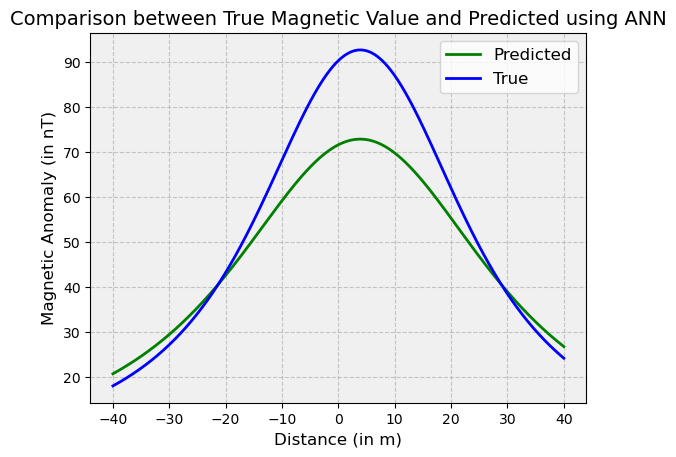

In [18]:
import matplotlib.pyplot as plt

plt.plot(x_values, magnetic_anomalies_matrix[0], label='Predicted', color='green', linewidth=2)
plt.plot(x_values, magnetic_anomalies_matrix1[0], label='True', color='blue', linewidth=2)

plt.title('Comparison between True Magnetic Value and Predicted using ANN', fontsize=14)
plt.xlabel('Distance (in m)', fontsize=12)
plt.ylabel('Magnetic Anomaly (in nT)', fontsize=12)


plt.grid(True, linestyle='--', alpha=0.7)


plt.legend(fontsize=12)

plt.gca().set_facecolor('#f0f0f0')


plt.show()


In [58]:
max(magnetic_anomalies_matrix1[0])

92.73132766099278